# Getting Started with TenSynth
## Your First Quantum Circuit from a Tensor Network

TenSynth is a Julia package for compiling quantum circuits from tensor network representations of quantum states and operators.

The core pipeline looks like this:

```
Quantum State (MPS)  -->  Decompose  -->  2-qubit gates  -->  Export (OpenQASM / Qiskit)
                              |                  |
                         analytical          (optional)
                           direct         Clifford+T synthesis
                         iterative
```

In this notebook you will:
1. Learn what a Matrix Product State (MPS) is
2. Create standard quantum states (product, GHZ, W, random)
3. Compile your first MPS into a quantum circuit
4. Compare decomposition methods
5. Export circuits to OpenQASM

## What is a Matrix Product State?

A Matrix Product State (MPS) factorises an $N$-qubit state vector $|\psi\rangle$ into a chain of rank-3 tensors:

$$|\psi\rangle = \sum_{s_1, \ldots, s_N} A^{s_1}_{1} A^{s_2}_{2} \cdots A^{s_N}_{N} \, |s_1 s_2 \cdots s_N\rangle$$

Each tensor $A^{s_i}_i$ has shape `[chi_left, d, chi_right]` where:
- `d = 2` is the physical (qubit) dimension
- `chi_left` and `chi_right` are **bond dimensions** connecting neighbouring sites

The bond dimension $\chi$ controls how much entanglement the MPS can represent:
- $\chi = 1$: product states (no entanglement)
- $\chi = 2$: states like GHZ and W
- $\chi \gg 1$: highly entangled states

TenSynth represents MPS as `FiniteMPS{ComplexF64}` objects.

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.MPS
# Import a few functions that aren't in the default export list
using TenSynth.MPS: wMPS, bond_dimensions, entanglement_entropy

using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("TenSynth loaded successfully.")

  Activating 

TenSynth loaded successfully.


project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


## 1. Creating Product States

Product states have bond dimension $\chi = 1$ (no entanglement between qubits).

In [2]:
# The all-zeros state |0000>
mps_zero = zeroMPS(4)
println("  |0000> bond dimensions: ", bond_dimensions(mps_zero))
println("  Max bond dim: ", max_bond_dim(mps_zero))
println()

# A product state from a bitstring
mps_product = productMPS("0110")
println("  |0110> bond dimensions: ", bond_dimensions(mps_product))
println("  Max bond dim: ", max_bond_dim(mps_product))

  |0000> bond dimensions: [1, 1, 1]
  Max bond dim: 1

  |0110> bond dimensions: [1, 1, 1]
  Max bond dim: 1


## 2. Creating Entangled States

Entangled states require bond dimension $\chi > 1$.

- **GHZ state**: $(|00\cdots0\rangle + |11\cdots1\rangle)/\sqrt{2}$ — maximally entangled in the computational basis
- **W state**: $(|10\cdots0\rangle + |01\cdots0\rangle + \cdots + |00\cdots1\rangle)/\sqrt{N}$ — a different entanglement structure

In [3]:
mps_ghz = ghzMPS(6)
mps_w = wMPS(6)

println("GHZ state (6 qubits):")
println("  Bond dimensions: ", bond_dimensions(mps_ghz))
println("  Max bond dim: ", max_bond_dim(mps_ghz))
println()
println("W state (6 qubits):")
println("  Bond dimensions: ", bond_dimensions(mps_w))
println("  Max bond dim: ", max_bond_dim(mps_w))

GHZ state (6 qubits):
  Bond dimensions: [2, 2, 2, 2, 2]
  Max bond dim: 2

W state (6 qubits):
  Bond dimensions: [2, 2, 2, 2, 2]
  Max bond dim: 2


Both states have bond dimension 2, but they encode very different entanglement structures. The GHZ state has a two-term superposition, while the W state distributes a single excitation across all qubits.

## 3. Inner Products and Fidelity

TenSynth can efficiently compute overlaps between MPS without expanding the full state vector.

In [4]:
# Self-overlap should be 1 (states are normalised)
println("GHZ self-overlap:  ", round(real(inner(mps_ghz, mps_ghz)), digits=10))
println("W self-overlap:    ", round(real(inner(mps_w, mps_w)), digits=10))
println()

# Fidelity between different states
println("GHZ-W fidelity:    ", round(fidelity(mps_ghz, mps_w), digits=10))
println("GHZ-|0> fidelity:  ", round(fidelity(mps_ghz, zeroMPS(6)), digits=10))
println()

# The unified cost() function: cost = 1 - fidelity
println("cost(GHZ, GHZ):    ", round(cost(mps_ghz, mps_ghz), digits=10))
println("cost(GHZ, W):      ", round(cost(mps_ghz, mps_w), digits=10))

GHZ self-overlap:  1.0
W self-overlap:    1.0

GHZ-W fidelity:    0.0
GHZ-|0> fidelity:  0.5

cost(GHZ, GHZ):    0.0
cost(GHZ, W):      1.0


## 4. Random MPS

Random MPS are useful for benchmarking. The bond dimension parameter `D` controls the entanglement capacity.

In [5]:
Random.seed!(42)

mps_rand2 = randMPS(6, 2)
mps_rand4 = randMPS(6, 4)
mps_rand8 = randMPS(6, 8)

for (label, mps) in [("chi=2", mps_rand2), ("chi=4", mps_rand4), ("chi=8", mps_rand8)]
    println("Random MPS ($label):")
    println("  Bond dimensions: ", bond_dimensions(mps))
    println("  Max bond dim: ", max_bond_dim(mps))
    println("  Entanglement entropy (mid-chain): ",
            round(entanglement_entropy(mps, 3), digits=4))
    println()
end

Random MPS (chi=2):
  Bond dimensions: [2, 2, 2, 2, 2]
  Max bond dim: 2
  Entanglement entropy (mid-chain): 0.4646

Random MPS (chi=4):
  Bond dimensions: [4, 4, 4, 4, 2]
  Max bond dim: 4
  Entanglement entropy (mid-chain): 0.9756

Random MPS (chi=8):
  Bond dimensions: [8, 8, 8, 4, 2]
  Max bond dim: 8
  Entanglement entropy (mid-chain): 1.427



## 5. Compiling an MPS to a Quantum Circuit

The `compile()` function is TenSynth's main entry point. It decomposes an MPS into a layered circuit of SU(4) two-qubit gates.

Three decomposition methods are available:
- **`:analytical`** — Fast SVD-based decomposition. Produces exact results for low bond dimension.
- **`:direct`** — Fixed-depth circuit with variational optimization.
- **`:iterative`** — Starts shallow and adds layers until the target fidelity is reached. Best quality.

In [6]:
# Compile the GHZ state using the analytical method.
# The analytical method is SVD-based and exact for low bond-dimension states like GHZ.
result_ghz = compile(mps_ghz;
    method=:analytical,
    synthesize_gates=false,  # skip Clifford+T synthesis for now
    verbose=false
)

# Display the result
result_ghz

CompilationResult:
  Qubits:            6
  Fidelity:          1.0
  Circuit depth:     20 layers
  2-qubit gates:     50
  Method:            :analytical
  Synthesis:         not performed
  Elapsed time:      24.23 seconds


### Inspecting the Result

`compile()` returns a `CompilationResult` with detailed statistics.

In [7]:
# Detailed statistics
stats = circuit_stats(result_ghz)
for (k, v) in pairs(stats)
    println("  $k = $v")
end

  n_qubits = 6
  circuit_depth = 20
  n_2q_gates = 50
  n_rz_rotations = 750
  n_t_gates = 0
  n_clifford_gates = 0
  fidelity = 0.999999999996763
  synthesis_error = 0.0


In [8]:
# Text-based circuit diagram
println(show_circuit(result_ghz))

q0: -*-----*-----*-----*-----*-----*-----*-----*-----*-----*----
     |     |     |     |     |     |     |     |     |     |    
q1: -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
        |     |     |     |     |     |     |     |     |     | 
q2: -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
     |     |     |     |     |     |     |     |     |     |    
q3: -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
        |     |     |     |     |     |     |     |     |     | 
q4: -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
     |     |     |     |     |     |     |     |     |     |    
q5: -*-----*-----*-----*-----*-----*-----*-----*-----*-----*----


## 6. Comparing Decomposition Methods

Let's compile a random MPS (bond dimension 4) using all three methods and compare fidelity, circuit depth, and compilation time.

In [9]:
Random.seed!(42)
mps_test = randMPS(6, 4)

methods = [:analytical, :direct, :iterative]
method_results = Dict{Symbol, NamedTuple}()

for m in methods
    t = @elapsed r = compile(mps_test;
        method=m,
        target_fidelity=0.99,
        max_layers=8,
        n_sweeps=50,
        synthesize_gates=false,
        verbose=false
    )
    method_results[m] = (
        fidelity = r.fidelity,
        depth = r.circuit_depth,
        n_gates = r.n_2q_gates,
        time = t
    )
    println("$(rpad(m, 12)) fidelity=$(round(r.fidelity, digits=6))  ",
            "depth=$(r.circuit_depth)  gates=$(r.n_2q_gates)  time=$(round(t, digits=2))s")
end

analytical   fidelity=0.996144  depth=8  gates=20  time=0.21s
direct       fidelity=0.999846  depth=7  gates=18  time=2.27s
iterative    fidelity=0.999846  depth=7  gates=18  time=2.27s


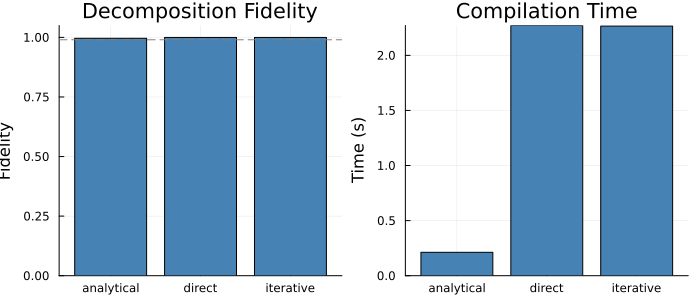

In [10]:
# Visualise the comparison
method_names = string.(methods)
fidelities = [method_results[m].fidelity for m in methods]
times = [method_results[m].time for m in methods]

p1 = bar(method_names, fidelities,
    ylabel="Fidelity", title="Decomposition Fidelity",
    legend=false, color=[:steelblue :coral :seagreen],
    ylims=(0, 1.05))
hline!(p1, [0.99], linestyle=:dash, color=:gray, label="")

p2 = bar(method_names, times,
    ylabel="Time (s)", title="Compilation Time",
    legend=false, color=[:steelblue :coral :seagreen])

plot(p1, p2, layout=(1, 2), size=(700, 300))

The **iterative** method generally achieves the highest fidelity because it adds circuit layers incrementally and optimises each one. The **analytical** method is fastest but may not reach high fidelity for complex states.

## 7. Exporting Circuits

TenSynth can export compiled circuits to standard quantum computing formats.

In [11]:
# Export the GHZ circuit to OpenQASM 2.0
qasm = to_openqasm(result_ghz)

# Show the first part of the QASM output
qasm_lines = split(qasm, '\n')
for line in qasm_lines[1:min(20, length(qasm_lines))]
    println(line)
end
if length(qasm_lines) > 20
    println("... ($(length(qasm_lines) - 20) more lines)")
end

OPENQASM 2.0;
include "qelib1.inc";

// TenSynth compilation result
// Fidelity: 1.0
// Method: analytical

qreg q[6];

// Layer 1
h q[1];
rz(-0.5001381505525002) q[1];
h q[1];
rz(-0.000192341716259744) q[1];
h q[1];
rz(-1.0704132900395509) q[1];
h q[1];
h q[0];
rz(-1.57080206921367) q[0];
h q[0];
... (2451 more lines)


You can also export to Python/Qiskit code with `to_qiskit()`, or save directly to a file with `save_circuit()`.

## Summary

In this notebook you learned how to:

- Create MPS representing quantum states: `zeroMPS`, `productMPS`, `ghzMPS`, `wMPS`, `randMPS`
- Inspect MPS properties: `bond_dimensions`, `max_bond_dim`, `entanglement_entropy`
- Compute overlaps: `inner`, `fidelity`, `cost`
- Compile MPS to quantum circuits: `compile` with methods `:analytical`, `:direct`, `:iterative`
- Inspect and export circuits: `circuit_stats`, `show_circuit`, `to_openqasm`

**Next**: Notebook 02 explores the relationship between entanglement entropy and circuit depth in detail.